# This notebook demonstrates how LIME - Local Interpretable Model-Agnostic Explanations can be used with models learnt with the AIF 360 toolkit to generate explanations for model predictions.

For more information on LIME, see [https://github.com/marcotcr/lime](https://github.com/marcotcr/lime).

In [1]:
from __future__ import print_function

%matplotlib inline

import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets
import sklearn.ensemble
import sklearn.preprocessing
import numpy as np
import lime
import lime.lime_tabular
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import numpy as np
from aif360.datasets import BinaryLabelDataset
from aif360.metrics.binary_label_dataset_metric import BinaryLabelDatasetMetric
from aif360.metrics.classification_metric import ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.reweighing import Reweighing



from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from aif360.datasets.lime_encoder import LimeEncoder 


from aif360.datasets.adult_dataset import AdultDataset

**Load dataset and display statistics**

In [2]:
np.random.seed(1)

dataset_orig = AdultDataset()
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)


In [3]:
# Metric for the original dataset
sens_attr = dataset_orig_train.protected_attribute_names[0]
sens_idx = dataset_orig_train.protected_attribute_names.index(sens_attr)
privileged_groups =  [{sens_attr:dataset_orig_train.privileged_protected_attributes[sens_idx][0]}] 
unprivileged_groups = [{sens_attr:dataset_orig_train.unprivileged_protected_attributes[sens_idx][0]}] 
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between privileged and unprivileged groups = -0.106968


**Transform the data using the Re-Weighing (pre-processing) algorithm**

In [4]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

**Learn and test models from the transformed data using Logistic Regression**

In [5]:
#Train model on given dataset

dataset = dataset_transf_train  # data to train on

scale = StandardScaler().fit(dataset.features)   # remember the scale

model = LogisticRegression()        # model to learn

X_train = scale.transform(dataset.features)      #apply the scale
y_train = dataset.labels.ravel()


model.fit(X_train, y_train, sample_weight=dataset.instance_weights)

#save model
lr_orig = model
lr_scale_orig = scale

In [6]:
#Test model on given dataset and find threshold for best balanced accuracy
import numpy as np
from tqdm import tqdm
thresh_arr = np.linspace(0.01, 0.5, 50)

scale = lr_scale_orig

model = lr_orig                  #model to test
dataset = dataset_orig_test        #data to test on

X_test = scale.transform(dataset.features)   #apply the same scale as applied to the training data
y_test = dataset.labels.ravel()
y_test_pred_prob = model.predict_proba(X_test)


bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
    
for thresh in tqdm(thresh_arr):
    y_test_pred = (y_test_pred_prob[:,1] > thresh).astype(np.double)

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_test_pred

    classified_metric = ClassificationMetric(dataset, 
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    
    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)
    
    acc = accuracy_score(y_true=dataset.labels,
                            y_pred=dataset_pred.labels)
    bal_acc_arr.append(bal_acc)
    avg_odds_diff_arr.append(classified_metric.average_odds_difference())
    disp_imp_arr.append(metric_pred.disparate_impact())
    
thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

100%|██████████| 50/50 [00:00<00:00, 61.75it/s]


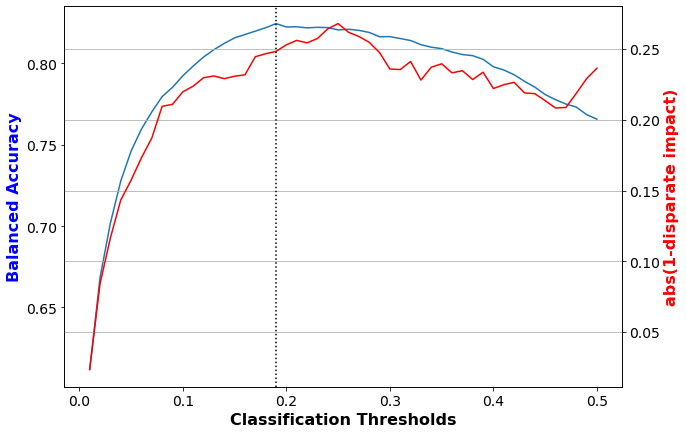

In [7]:
#Plot balanced accuracy, abs(1-disparate impact)

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, np.abs(1.0-np.array(disp_imp_arr)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

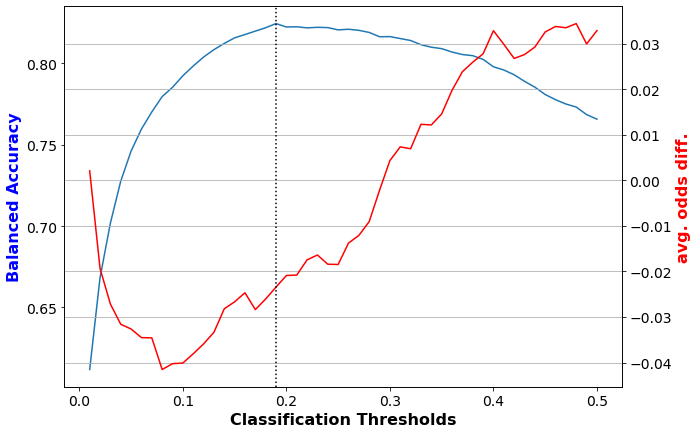

In [8]:
#Plot average odds difference
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, avg_odds_diff_arr, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [9]:
rf_thresh_arr_orig_best = thresh_arr_best
print("Threshold corresponding to Best balance accuracy: %6.4f" % rf_thresh_arr_orig_best)
rf_best_bal_acc_arr_orig = best_bal_acc
print("Best balance accuracy: %6.4f" % rf_best_bal_acc_arr_orig)
rf_disp_imp_at_best_bal_acc_orig = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % rf_disp_imp_at_best_bal_acc_orig)
rf_avg_odds_diff_at_best_bal_acc_orig = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % rf_avg_odds_diff_at_best_bal_acc_orig)

Threshold corresponding to Best balance accuracy: 0.1900
Best balance accuracy: 0.8245
Corresponding abs(1-disparate impact) value: 0.2483
Corresponding average odds difference value: -0.0234


** Use LIME to generate explanations for predictions made using the learnt Logistic Regression model**

Threshold corresponding to Best balance accuracy: 0.1900
        Actual label: [1.]
        Actual label: [0.]


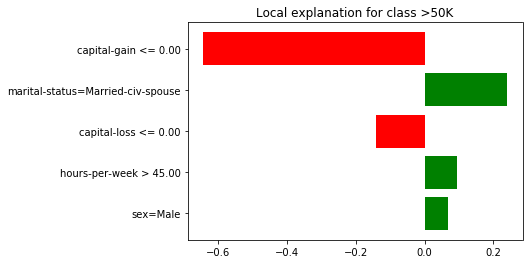

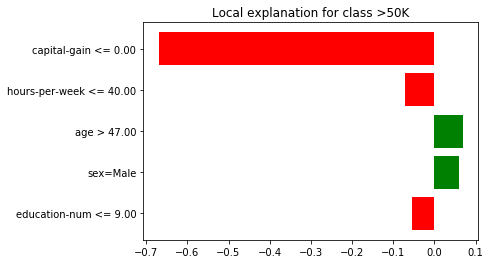

In [10]:
limeData = LimeEncoder().fit(dataset_orig_train)
s_train = limeData.transform(dataset_orig_train.features)
s_test = limeData.transform(dataset_orig_test.features)

scale = lr_scale_orig

model = lr_orig                  #model to test




explainer = lime.lime_tabular.LimeTabularExplainer(s_train ,class_names=limeData.s_class_names, 
                                                   feature_names = limeData.s_feature_names,
                                                   categorical_features=limeData.s_categorical_features, 
                                                   categorical_names=limeData.s_categorical_names, 
                                                   kernel_width=3, verbose=False,discretize_continuous=True)

s_predict_fn = lambda x: model.predict_proba(scale.transform(limeData.inverse_transform(x)))

import random
print("Threshold corresponding to Best balance accuracy: %6.4f" % rf_thresh_arr_orig_best)
i1 = 1
exp = explainer.explain_instance(s_test[i1], s_predict_fn, num_features=5)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_orig_test.labels[i1]))

i2 = 100
exp = explainer.explain_instance(s_test[i2], s_predict_fn, num_features=5)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_orig_test.labels[i2]))



**Learn and test models from the transformed data using Random Forests**

In [11]:
#Train model on given dataset

dataset = dataset_transf_train  # data to train on

scale = StandardScaler().fit(dataset.features)   # remember the scale

model = sklearn.ensemble.RandomForestClassifier(n_estimators=500)       # model to learn

X_train = scale.transform(dataset.features)      #apply the scale
y_train = dataset.labels.ravel()


model.fit(X_train, y_train, sample_weight=dataset.instance_weights)

#save model
rf_orig = model
rf_scale_orig = scale

In [12]:
#Test model on given dataset and find threshold for best balanced accuracy
import numpy as np
from tqdm import tqdm
thresh_arr = np.linspace(0.01, 0.5, 50)

scale = rf_scale_orig

model = rf_orig                  #model to test
dataset = dataset_orig_test        #data to test on

X_test = scale.transform(dataset.features)   #apply the same scale as applied to the training data
y_test = dataset.labels.ravel()
y_test_pred_prob = model.predict_proba(X_test)


bal_acc_arr = []
disp_imp_arr = []
avg_odds_diff_arr = []
    
for thresh in tqdm(thresh_arr):
    y_test_pred = (y_test_pred_prob[:,1] > thresh).astype(np.double)

    dataset_pred = dataset.copy()
    dataset_pred.labels = y_test_pred

    classified_metric = ClassificationMetric(dataset, 
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    
    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)
    
    acc = accuracy_score(y_true=dataset.labels,
                            y_pred=dataset_pred.labels)
    bal_acc_arr.append(bal_acc)
    avg_odds_diff_arr.append(classified_metric.average_odds_difference())
    disp_imp_arr.append(metric_pred.disparate_impact())
    
thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
disp_imp_at_best_bal_acc = np.abs(1.0-np.array(disp_imp_arr))[thresh_arr_best_ind]

avg_odds_diff_at_best_bal_acc = avg_odds_diff_arr[thresh_arr_best_ind]

100%|██████████| 50/50 [00:00<00:00, 76.17it/s]


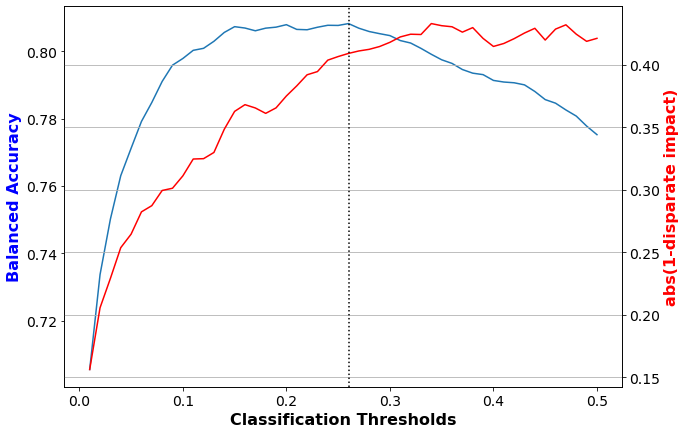

In [13]:
#Plot balanced accuracy, abs(1-disparate impact)

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, np.abs(1.0-np.array(disp_imp_arr)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], 
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

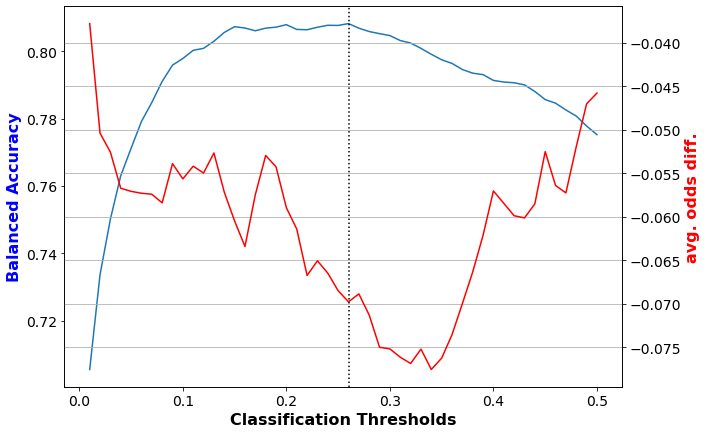

In [14]:
#Plot average odds difference
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(thresh_arr, bal_acc_arr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(thresh_arr, avg_odds_diff_arr, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')

ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [15]:
rf_thresh_arr_orig_best = thresh_arr_best
print("Threshold corresponding to Best balance accuracy: %6.4f" % rf_thresh_arr_orig_best)
rf_best_bal_acc_arr_orig = best_bal_acc
print("Best balance accuracy: %6.4f" % rf_best_bal_acc_arr_orig)
rf_disp_imp_at_best_bal_acc_orig = disp_imp_at_best_bal_acc
print("Corresponding abs(1-disparate impact) value: %6.4f" % rf_disp_imp_at_best_bal_acc_orig)
rf_avg_odds_diff_at_best_bal_acc_orig = avg_odds_diff_at_best_bal_acc
print("Corresponding average odds difference value: %6.4f" % rf_avg_odds_diff_at_best_bal_acc_orig)

Threshold corresponding to Best balance accuracy: 0.2600
Best balance accuracy: 0.8083
Corresponding abs(1-disparate impact) value: 0.4090
Corresponding average odds difference value: -0.0698


** Use LIME to generate explanations for predictions made using the learnt Logistic Regression model**

Threshold corresponding to Best balance accuracy: 0.2600
        Actual label: [1.]
        Actual label: [0.]


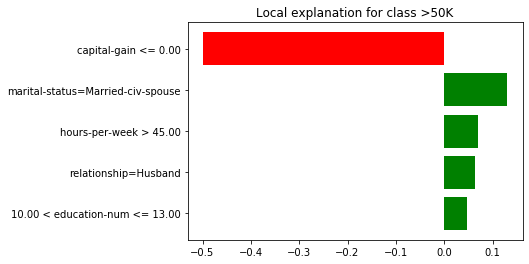

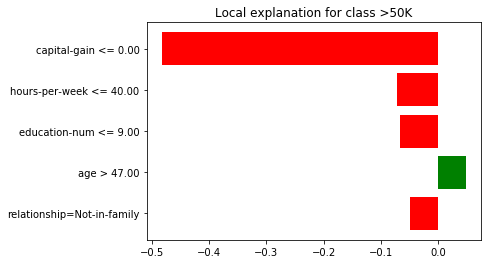

In [16]:
limeData = LimeEncoder().fit(dataset_orig_train)
s_train = limeData.transform(dataset_orig_train.features)
s_test = limeData.transform(dataset_orig_test.features)

scale = rf_scale_orig

model = rf_orig                  #model to test




explainer = lime.lime_tabular.LimeTabularExplainer(s_train ,class_names=limeData.s_class_names, 
                                                   feature_names = limeData.s_feature_names,
                                                   categorical_features=limeData.s_categorical_features, 
                                                   categorical_names=limeData.s_categorical_names, 
                                                   kernel_width=3, verbose=False,discretize_continuous=True)

s_predict_fn = lambda x: model.predict_proba(scale.transform(limeData.inverse_transform(x)))

import random
print("Threshold corresponding to Best balance accuracy: %6.4f" % rf_thresh_arr_orig_best)

exp = explainer.explain_instance(s_test[i1], s_predict_fn, num_features=5)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_orig_test.labels[i1]))


exp = explainer.explain_instance(s_test[i2], s_predict_fn, num_features=5)
exp.as_pyplot_figure()
print("        Actual label: " + str(dataset_orig_test.labels[i2]))

